## Domácí úkol: Lineární regrese pro předpověď  šance na přijetí na vysokou školu


In [1]:
# Autor: Kateřina Chmelařová
# 1. úkol Python pro datovou vědu
# Zpracovala dne 4.5.2024

In [ ]:
# cíl: Vytvořte model lineární regrese, který na základě dostupných údajů předpoví šanci na přijetí na vysokou školu

In [141]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import OLSInfluence


In [94]:
data = pd.read_csv("adm_data.csv")
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [95]:
data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


In [96]:
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [97]:
data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [98]:
data = data.rename(columns={'Serial No.':'Serial_No.', 'GRE Score':'GRE_Score', 'TOEFL Score':'TOEFL_Score', 'University Rating':'University_Rating', 'SOP':'SOP',
       'LOR ':'LOR', 'CGPA':'CGPA', 'Research':'Research', 'Chance of Admit ':'Chance_of_Admit'})
data.head()


,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [99]:
data.describe()
data.shape

(400, 9)

### Normálnost dat pro TOEFL skóre

In [100]:
# 1. Vypočítejte průměr a medián pro TOELF skóre
print(data["TOEFL_Score"].mean())

107.41


In [101]:
# Vypočítejte medián
print(data["TOEFL_Score"].median())

107.0


In [102]:
# 2. Vypočítejte směrodatnou odchylku
std = data["TOEFL_Score"].std()
std

6.069513777374126

<AxesSubplot: xlabel='TOEFL_Score', ylabel='Count'>

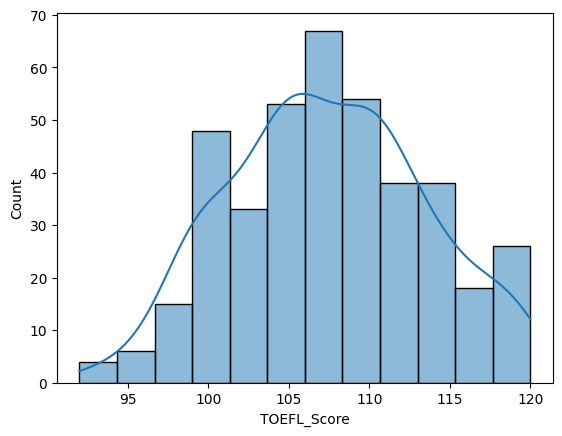

In [103]:
# 3. Vytvořte histogram pro TOEFL skóre a nezapomeňte zobrazit odhadovanou křivku pravděpodobnostního rozdělení

sns.histplot(data['TOEFL_Score'], kde=True)
# zobrazení odhadované křivky pravděpodobnostního rozdělení s parametrem kde

In [104]:
# 4. Otestujte, zda je TOEFL skóre vybráno z normálního rozdělení pomocí statistického testu. Uvažujte hladinu.
# Hypotézy pro tento test:

#H0: Data mají normální rozdělení.
#H1: Data nemají normální rozdělení.

In [105]:
stats.normaltest(data["TOEFL_Score"])

NormaltestResult(statistic=11.070212103496331, pvalue=0.003945790155853822)

In [106]:
# p-hodnota je statisticky významná na 5% hladině významnosti, zamítám tedy nulovou hypotézu, 
# Tvrdím, že data nemají normální rozdělení

### Testování hypotéz

In [107]:
# 1. Rozdělte data na studenty, kteří mají a nemají zkušenost s výzkumem

In [108]:
research_experienced = data[data["Research"] == 1]
research_unexperienced = data[data["Research"] == 0]

In [109]:
research_experienced

,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
5,6,330,115,5,4.5,3.0,9.34,1,0.90
...,...,...,...,...,...,...,...,...,...
394,395,329,111,4,4.5,4.0,9.23,1,0.89
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91


In [110]:
research_unexperienced

,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
4,5,314,103,2,2.0,3.0,8.21,0,0.65
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45
15,16,314,105,3,3.5,2.5,8.30,0,0.54
...,...,...,...,...,...,...,...,...,...
388,389,296,97,2,1.5,2.0,7.80,0,0.49
390,391,314,102,2,2.0,2.5,8.24,0,0.64
391,392,318,106,3,2.0,3.0,8.65,0,0.71
393,394,317,104,2,3.0,3.0,8.76,0,0.77


In [112]:
# 2. Pro obě skupiny spočítejte průměrné GRE skóre

In [113]:
research_experienced["GRE_Score"].mean()

322.85388127853884

In [114]:
research_unexperienced["GRE_Score"].mean()

309.49171270718233

In [115]:
# 3. Statisticky otestujte, zda existuje statisticky významný rozdíl v GRE skóre mezi těmito dvěma skupinami 
# studentů. Vyberte správný test a nezapomeňte krátce okomentovat vyhodnocení testu.

# Hypotézy
# H0: Data mají normální rozdělení.
# H1: Data nemají normální rozdělení.

# Chci tedy zjistit, zda data mají normální rozdělení
stats.normaltest(research_experienced["GRE_Score"])
# P-hodnota prvního testu je 0.00514, zamítám tedy nulovou hypotézu. Výsledek je, že data nemají normální rozdělení.

NormaltestResult(statistic=10.539299481397224, pvalue=0.005145412486026274)

In [116]:
stats.normaltest(research_unexperienced["GRE_Score"])
# P-hodnota druhéto testu je 0.60767, nemohu tedy zamítnout nulovou hypotézu - data mají normální rozdělení

NormaltestResult(statistic=0.9962407495635873, pvalue=0.6076717821415272)

In [117]:
# Pokuď ale jeden z nich nemá normální rozdělení, musím použít Mann Whitney U test na základě:
# tj. potřebuji dvouvýběrový test (2 vzorky)
# porovnávám střední hodnotu (průměr) výběrů
# data nemají normální rozdělení
# výběry jsou nezávislé, nejde o párová pozorování

#Formuluji si hypotézy.

#H0: Střední hodnota GRE_Score pro obě skupiny jsou stejné.
#H1: Střední hodnota GRE_Score pro obě skupiny se liší.


In [118]:
statistics, pvalue = stats.mannwhitneyu(research_experienced["GRE_Score"], research_unexperienced["GRE_Score"])
pvalue

1.1433386421648099e-32

In [119]:
# p-hodnota je 1.1433386421648099e-32, zamítám tedy nulovou hypotézu. Tvrdím tedy, že průměrné GRE_Score pro skupinu 
# se zkušenostmi s testem a bez zkušeností s testem se liší na 5% hladině významnosti


### Korelace

In [120]:
# 1. Vypočítejte korelaci mezi TOEFL skóre a GRE skóre
data[["TOEFL_Score","GRE_Score"]].corr()
# Vypočítaná korelace mezi TOEFL a GRE skóre je 0.835977

,TOEFL_Score,GRE_Score
TOEFL_Score,1.000000,0.835977
GRE_Score,0.835977,1.000000


<AxesSubplot: xlabel='TOEFL_Score', ylabel='GRE_Score'>

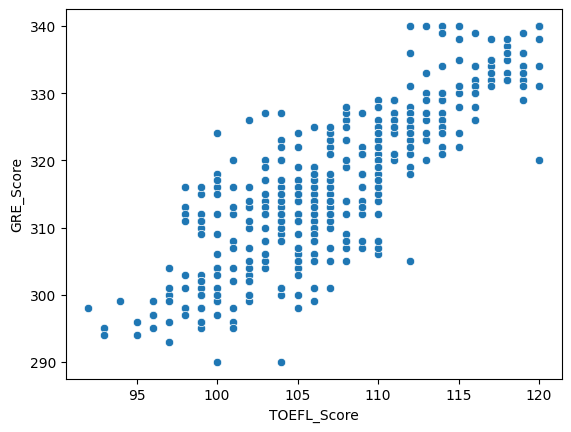

In [121]:
sns.scatterplot(data=data, x="TOEFL_Score", y="GRE_Score")

In [122]:
data.corr()

,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
Serial_No.,1.000000,-0.097526,-0.147932,-0.169948,-0.166932,-0.088221,-0.045608,-0.063138,0.042336
GRE_Score,-0.097526,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391,0.802610
TOEFL_Score,-0.147932,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858,0.791594
University_Rating,-0.169948,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783,0.711250
SOP,-0.166932,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029,0.675732
LOR,-0.088221,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859,0.669889
CGPA,-0.045608,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654,0.873289
Research,-0.063138,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000,0.553202
Chance_of_Admit,0.042336,0.802610,0.791594,0.711250,0.675732,0.669889,0.873289,0.553202,1.000000


In [123]:
res = stats.spearmanr(data["TOEFL_Score"], data["GRE_Score"])
res
# Data jsou statisticky významné na 5% hladině významnosti

SignificanceResult(statistic=0.8318602076053343, pvalue=8.038920665153277e-104)

In [124]:
# 2. Krátce okomentujre, co znamená vypočítaná korelace. Je tato korelace vysoká, pozitivní/negativní?
# Vypočítaná korelace je vysoká a pozitivní. Dle Spearmanova koeficientu jsou statisticky 
# závislé na 5% hladině významnosti

In [125]:
# 3. Vytvořte korelační graf (sns.regplot) pro vysvětlovanou proměnnou šance na přijetí (Chance of Admit)
# a proměnnou, která je s ní nejvíce korelovaná

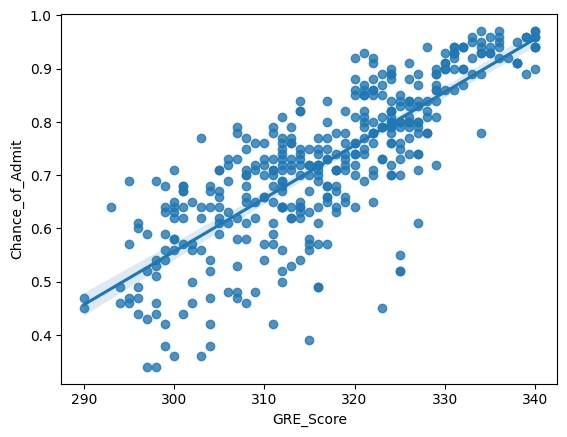

In [126]:
g = sns.regplot(data, x="GRE_Score", y="Chance_of_Admit")

In [81]:
# Nejvíce korelovaná proměnná s vysvětlovanou proměnnou Chance of Admit je proměnná GRE_Score.

### Vysvětlovaná proměnná

In [83]:
# 1. Vysvětlovanou proměnnou je šance na přijetí (Chance of Admit). Vytvořte boxplot pro tuto proměnnou, 
# aby bylo možné vizuálně identifikovat případné odlehlé hodnoty. 

<AxesSubplot: ylabel='Chance_of_Admit'>

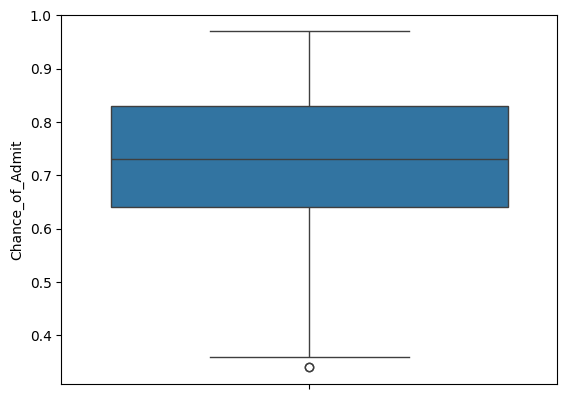

In [135]:
sns.boxplot(data, y="Chance_of_Admit")

In [136]:
# 2. Odstraňte odlehlé pozorování na základě kritérií zjištěných z boxplotu.

In [138]:
data_bez_odlehlych = data[data["Chance_of_Admit"] > 0.35]

<AxesSubplot: ylabel='Chance_of_Admit'>

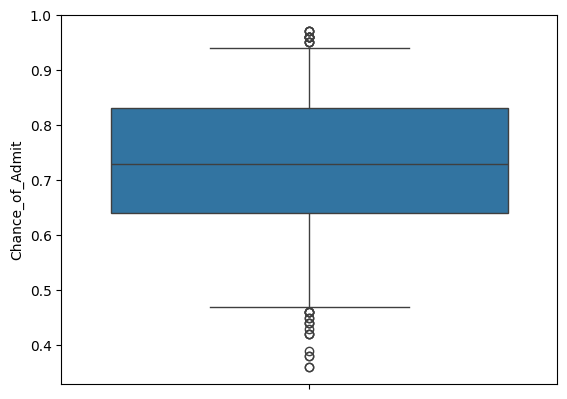

In [139]:
sns.boxplot(data_bez_odlehlych, y="Chance_of_Admit",whis=[5, 95])

### Lineární regrese

In [140]:
#1. Sestavte rovnici pro lineární regresi. Do rovnice zahrňte všechny proměnné, které dávají smysl. 
# Pozor, možná bude potřeba názvy sloupců přejmenovat 

In [148]:
formula = "Chance_of_Admit ~ GRE_Score + TOEFL_Score + University_Rating + SOP + LOR + CGPA + Research"  # vysvětlovaná ~ vysvětlující
mod = smf.ols(formula=formula, data=data_bez_odlehlych) #OLS dělá ordinary least squares 
results = mod.fit() # přímku, který popisuje data 
influence = OLSInfluence(results)
data['Cook Distance'] = influence.cooks_distance[0]
data.head()
#results.summary()

# Zvolila jsem všechny vysvětlující proměnné, které vyšly v korelační tabulce vyšší než 0.5 s Chance of Admit

,Serial_No.,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit,Cook Distance
0,1,337,118,4,4.5,4.5,9.65,1,0.92,0.000383
1,2,324,107,4,4.0,4.5,8.87,1,0.76,0.000811
2,3,316,104,3,3.0,3.5,8.00,1,0.72,0.002403
3,4,322,110,3,3.5,2.5,8.67,1,0.80,0.001627
4,5,314,103,2,2.0,3.0,8.21,0,0.65,0.000098


In [149]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance_of_Admit   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     229.9
Date:                Fri, 03 May 2024   Prob (F-statistic):          3.78e-134
Time:                        16:09:15   Log-Likelihood:                 542.56
No. Observations:                 398   AIC:                            -1069.
Df Residuals:                     390   BIC:                            -1037.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2107      0.123     -9.855      0.000      -1.452      -0.969
GRE_Score             0.0017      0.001      2.843      0.005       0.001       0.003
TOEFL_Score           0.0026      0.001      2.467      0.014       0.001       0.005
University_Rating     0.0054      0.005      1.147      0.252      -0.004       0.015
SOP                  -0.0003      0.005     -0.063      0.950      -0.011       0.010
LOR                   0.0210      0.005      3.861      0.000       0.010       0.032
CGPA                  0.1190      0.012      9.920      0.000       0.095       0.143
Research              0.0237      0.008      3.040      0.003       0.008       0.039
==============================================================================
Omnibus:                       88.327   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.308
Skew:                          -1.164   Prob(JB):                     9.50e-41
Kurtosis:                       5.386   Cond. No.                     1.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [150]:
# 2. Odhadněte parametry lineárního regresního modelu

In [ ]:
# Na odhad parametrů použijeme metodu nejmenších čtverců OLS 


In [151]:
# 3. Interpretujte koeficienty modelu. Které koeficienty jsou statisticky významé? Diskutujte, které proměnné 
# mají největší vliv na šance na přijetí a proč.

# Výsledky regresní analýzy pomocí metody nejmenších čtverců (OLS) pro závislou proměnnou "Chance of Admit" (šance na přijetí) 
# ukazují, jak GRE Skóre, TOEFL Skóre, hodnocení od univerzity, SOP, LOR, CGPA, a účast na výzkumu ovlivňují šanci na přijetí.
# Model využívá pouze tyto nezávislé proměnné a jeho charakteristiky jsou následující:

# R-squared (R²) = 0.805. Model dokáže vysvětlit 80.5% variability v šanci na přijetí na nezávislých proměnných uvedených v tomto modelu.
# Adjusted R-squared (Adj. R²) = 0.801. Upravený koeficient determinace je velmi blízký R². To ukazuje, že model není zatížen nadbytečným počtem proměnných.

# F-statistika = 229.9 s p-hodnota = 3.78e-134: Tato statistika a velmi nízká p-hodnota ukazují, že model jako celek je statisticky významný. 
# To znamená, že alespoň jeden z koeficientů (GRE_Score, TOEFL_Score, University_Rating, SOP, LOR, CGPA, Research) má statisticky významný vliv na šanci na přijetí.

# Koeficienty:
# Intercept(konstanta) je -1.2107 s p-hodnotou < 0.0001. Intercept je statisticky významný a jeho negativní hodnota není iterpretabilní bez dalších informací.
# GRE_Score: Koeficient 0.0017 znamená, že se každým dalším Gre score bodem se šance na přijetí zvyšuje o 0.0017. p = 0.005.
# TOEFL_Score: Koeficient 0.0026 znamená, že se každým dalším bodem z TOEFL se šance na přijetí zvyšuje o 0.0026. p = 0.014.
# University_Rating: Koeficient 0.0054 znamená, že se každým dalším bodem od univerzity se šance na přijetí zvyšuje o 0.0054. p = 0.252 
# SOP: Koeficient -0.0003 znamená, že s každou další změnou o 0.1 SOP se šance na přijetí snižuje o 0.0003. p = 0.950
# LOR: Koeficient 0.0210 znamená, že s každou další změnou o 0.1 LOR se šance na přijetí zvyšuje o 0.0210. p = 0.000 
# CGPA: Koeficient 0.1190 znamená, že s každou další změnou o 0.01 CGPAse šance na přijetí zvyšuje o 0.1190. p = 0.000
# Research: Koeficient 0.0237 znamená, že má-li student zkušenost s výzkumem se šance na přijetí zvyšuje o 0.0237. p = 0.003

# Diagnostika reziduí:
# Omnibus test: Výsledek testu je statisticky významný (p < 0.001), což naznačuje, že rezidua nejsou normálně distribuovaná.
# Skew (šikmost) a Kurtosis (špičatost): Hodnoty ukazují, že distribuce reziduí má vyšší špičatost a je více šikmá (v negativním směru) než normální distribuce.

# Zhodnocení modelu
# Model má dobré vysvětlující schopnosti.
# R-squared hodnoty jsou vysoké, model dokáže vysvětlit 80.5% variability v šanci na přijetí.
# Koeficienty nejsou příliš významné, ale to se dá pochopit, protože 1 bod ještě nemůže zvýšit šanci o přijetí o desítky procent.
# Z těchto proměnných by mohla mít největší vliv na přijetí CGPA, protože změna o 0.01 bodu zvyšuje šanci o přijetí o 0.1190.

In [ ]:
# 4. Vyhodnoťte kvalitu fitu vašeho lineárního regresního modelu pomocí koeficientu determinace R2.
# Viz předchozí odpověď, kde jsem to popsala

In [158]:
# 5. Vypočítejte Cookovu vzdálenost pro jednotlivé body
# Viz bod #1
data['Cook Distance'] = influence.cooks_distance[0]
data[['Cook Distance']]

,Cook Distance
0,0.000383
1,0.000811
2,0.002403
3,0.001627
4,0.000098
...,...
395,0.000038
396,0.000466
397,0.000001
398,0.001594


<AxesSubplot: xlabel='Cook Distance', ylabel='Count'>

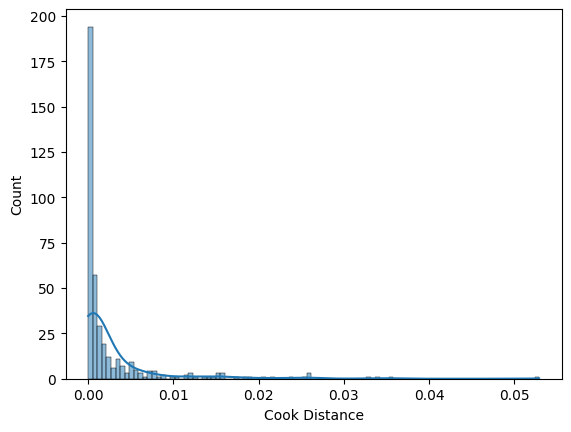

In [166]:
# 6. Vytvořte histogram pro Cookovu zdálenost. Je potřeba nějaké body odstranit, protože by moc ovlivňovali
# naši lineární regresi?
# Můžeme odstranit body nad 0.02
sns.histplot(data['Cook Distance'], kde=True)

In [168]:
data_modif = data[data['Cook Distance'] < 0.02] # zobraz jen body menší než 1
mod = smf.ols(formula=formula, data=data_modif)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance_of_Admit   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     299.8
Date:                Sat, 04 May 2024   Prob (F-statistic):          3.01e-150
Time:                        18:12:03   Log-Likelihood:                 589.06
No. Observations:                 387   AIC:                            -1162.
Df Residuals:                     379   BIC:                            -1130.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2736      0.108    -11.784      0.000      -1.486      -1.061
GRE_Score             0.0023      0.001      4.468      0.000       0.001       0.003
TOEFL_Score           0.0028      0.001      3.058      0.002       0.001       0.005
University_Rating     0.0098      0.004      2.385      0.018       0.002       0.018
SOP                  -0.0007      0.005     -0.140      0.889      -0.010       0.009
LOR                   0.0213      0.005      4.539      0.000       0.012       0.030
CGPA                  0.1010      0.010      9.674      0.000       0.080       0.122
Research              0.0146      0.007      2.136      0.033       0.001       0.028
==============================================================================
Omnibus:                       47.929   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.181
Skew:                          -0.796   Prob(JB):                     1.29e-16
Kurtosis:                       4.416   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot: xlabel='Cook Distance', ylabel='Count'>

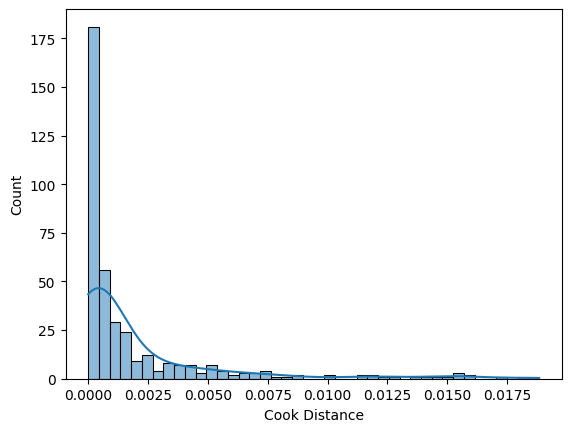

In [172]:
sns.histplot(data_modif['Cook Distance'], kde=True)